# TODO: Time feature engineering
* #### ~~Try to reverese engineer these pca transformed features and find out what each one is :D so we can perform more effective feature engineering~~
* #### Ok nvm, this whole reverse feature engineering thing seems like a strech too far and might lead to minimal, no benefits or even result in worse results if we assume something wrong

In [20]:
!pip install mplcyberpunk

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
import os
from pathlib import Path
import xgboost as xgb
import lightgbm as lgbm
import catboost
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import optuna
from sklearn.preprocessing import StandardScaler
from scipy.linalg import norm
from category_encoders import LeaveOneOutEncoder

In [5]:
from warnings import filterwarnings
filterwarnings("ignore")

In [6]:
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey
# plt.grid(color='#2A3459')  # bluish dark grey, but slightly lighter than background

In [26]:
BASE_PATH = Path("/kaggle/input/playground-series-s3e4")

train = pd.read_csv(BASE_PATH / "train.csv")
test = pd.read_csv(BASE_PATH / "test.csv")

original = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

print(f"Training dataset has {len(train)} rows with " \
                    f"{sum(train.Class) / len(train) * 100 :.2}% fraud rows.")
print(f"Original dataset has {len(original)} rows with " \
                    f"{sum(original.Class) / len(original) * 100 :.2}% fraud rows.")

Training dataset has 219129 rows with 0.21% fraud rows.
Original dataset has 284807 rows with 0.17% fraud rows.


In [8]:
y = train.Class
X = train.drop(columns=["id", "Class"])
X_test = test.drop(columns="id")

# Let's see if there are any Categorical Features

In [9]:
(pd.concat([train.nunique().rename("n_unique"),
           round((train.nunique()/len(train) * 100).rename("%_unique"), 2)], axis=1)
        .sort_values(by="%_unique")
)

,n_unique,%_unique
Class,2,0.00
Amount,19585,8.94
Time,36845,16.81
V6,217594,99.30
V5,217661,99.33
V24,217687,99.34
V8,217679,99.34
V9,217681,99.34
V11,217680,99.34
V3,217700,99.35


### INSIGHTS: AH, so looks like we've got no categorical features for this dataset! So weird!

# Tuning without feature engineering or additional data

In [10]:
# from optuna.integration import LightGBMPruningCallback

# def objective_lgbm(trial, X, y):
#     param_grid = {
#         "device_type": "gpu",
#         "n_estimators": trial.suggest_int("n_estimators", 100, 3000),
#         "num_rounds": trial.suggest_int("num_rounds", 100, 3000),
#         "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.3),
#         "num_leaves": trial.suggest_int("num_leaves", 20, 200),
#         "max_depth": trial.suggest_int("max_depth", 2, 20),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
#         "lambda_l1": trial.suggest_loguniform('lambda_l1', 0.00001, 10),
#         "lambda_l2": trial.suggest_loguniform('lambda_l2', 0.00001, 10),
#         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 100),
#         "bagging_fraction":  trial.suggest_loguniform('bagging_fraction', 0.2, 0.9),
#         "feature_fraction": trial.suggest_loguniform('feature_fraction', 0.2, 0.9),
#         "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 50, 500),
#         "verbose": -1,
#     }

#     N_FOLDS = 10
#     all_scores = np.zeros(N_FOLDS)

#     skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)

#     for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        
#         X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

            
#         model = lgbm.LGBMClassifier(objective="binary", is_unbalance=True, **param_grid)
#         model.fit(
#             X_tr,
#             y_tr,
#             eval_set=[(X_val, y_val)],
#             eval_metric="auc",
#             verbose=-1,
#         )
#         y_preds = model.predict_proba(X_val)[:, 1]
#         all_scores[fold_id] = roc_auc_score(y_val, y_preds)
    
#     auc = np.mean(all_scores)
#     print(f"AVG CV AUC: \t {auc}")
#     return auc

In [11]:
# study_lgbm = optuna.create_study(direction="maximize", study_name="LGBM Tuning")
# func = lambda trial: objective_lgbm(trial, X, y)
# study_lgbm.optimize(func, n_trials=100, show_progress_bar=True)

In [12]:
# study_lgbm.best_value

In [13]:
# study_lgbm.best_params

## INSIGHTS:
Without any feature engineering or adding original data, we get to a value of 81.26

# Let's do some feature engineering

In [14]:
train_time_unique = train.Time.drop_duplicates().reset_index(drop=True)

In [16]:
# converting the time feature back to hours from seconds
pd.DataFrame(((train_time_unique//3600) % 24).rename("Hour"))

,Hour
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
36840,9.0
36841,9.0
36842,9.0
36843,9.0


In [57]:
# let's add it to our dataset
train["Hour"] = (train.Time // 3600) % 24
test["Hour"] = (test.Time // 3600) % 24
original["Hour"] = (original.Time // 3600) % 24
train.Hour.tail()

219124    9.0
219125    9.0
219126    9.0
219127    9.0
219128    9.0
Name: Hour, dtype: float64

### Based on the book, we can add a new feature based on time, is_night
if hour <= 6 or from 00:00 to 06:00 AM will be considered night will the rest will be considered daytime

In [65]:
train["is_night"] = train.Hour.map(lambda x: int(x <= 6))
test["is_night"] = test.Hour.map(lambda x: int(x <= 6))
original["is_night"] = test.Hour.map(lambda x: int(x <= 6))

In [61]:
# # let's also add day to our dataset
# (train_time_unique // (24 * 3600)) % 7

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
36840    1.0
36841    1.0
36842    1.0
36843    1.0
36844    1.0
Name: Time, Length: 36845, dtype: float64

In [ ]:
# train["Day"] = train.Time // (24 * 3600) % 7
# test["Day"] =  test.Time // (24 * 3600) % 7

## HOLD UP:
Okay so i was about to add day to the dataset but what good will it bring? Like we know even the hidden dataset is going to span at most 2 days, so the feature engineering that I had in mind based on that book, will yield nothing good as we cant differentaite weekday and weekend.

## INSIGHTS: 
* Hold on hold on, the whole dataset contains transactions of **two days** just like the original dataset!
* Competition Traning Set contains transactions from **12AM to 9 AM of the next day**, basically of 33 hours
* While the test set contains from **9AM (where the train data left off) till 23 or 11:59 PM**

# note that all the analysis below were done using pre-feature egnineered datasets - ;/

# Let's plot these feature distributions for further analysis

In [22]:
plt.style.use("cyberpunk")

In [31]:
train.columns

Index(['id', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [32]:
numerical_feats = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

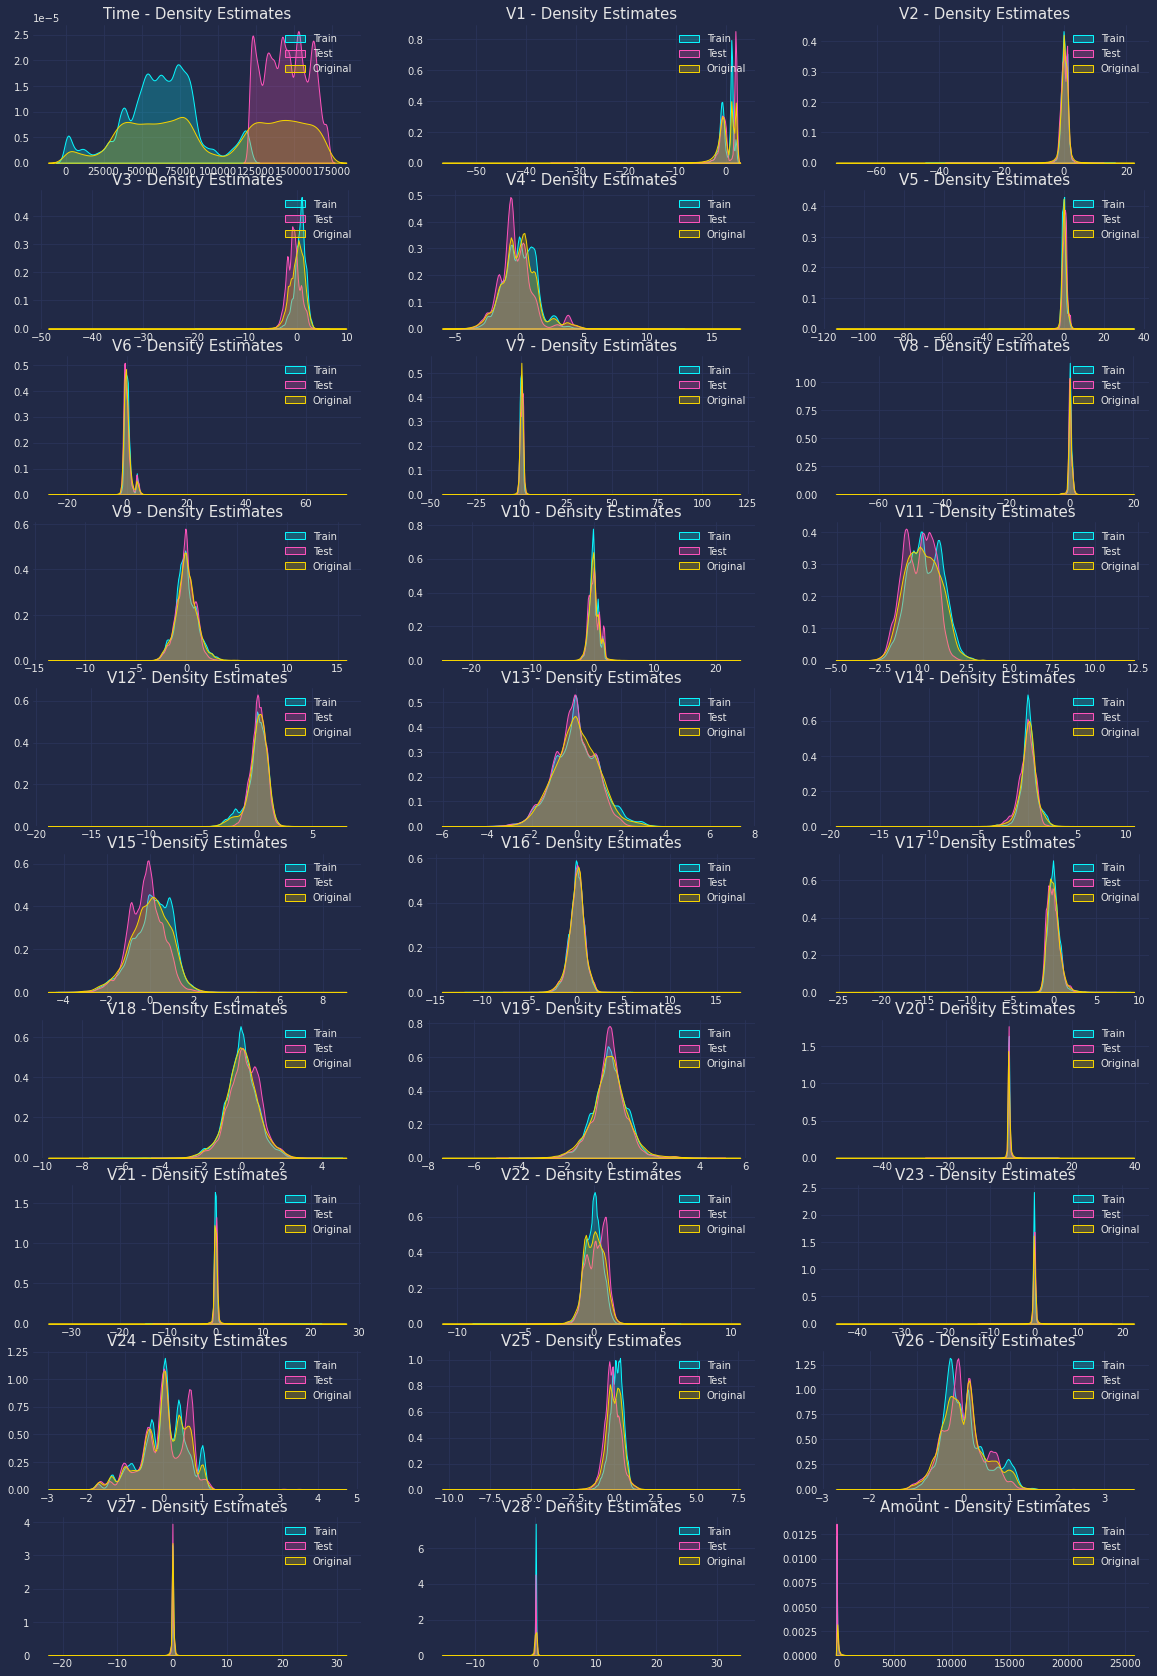

In [33]:
# len(numerical_feats)

fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(20, 30))
axs = axs.flatten()

for ax_counter, feature in enumerate(numerical_feats):
    _ = sns.kdeplot(train[feature], shade=True, ax=axs[ax_counter], label="Train")
    _ = sns.kdeplot(test[feature], shade=True, ax=axs[ax_counter], label="Test")
    _ = sns.kdeplot(original[feature], shade=True, ax=axs[ax_counter], label="Original")
    
    _ = axs[ax_counter].set_title("{} - Density Estimates".format(feature), fontsize=15)
    _ = axs[ax_counter].set_ylabel("")
    _ = axs[ax_counter].set_xlabel("")
    
    handles, labels = axs[ax_counter].get_legend_handles_labels()
    axs[ax_counter].legend(handles=handles, labels=labels, title="")

# Let's do some digging based on this book which in turn is based on the original card fraud detection dataset
Book link: https://fraud-detection-handbook.github.io/

### First, let's see if these are some feature values that are present more time in case of a fraud than others

In [34]:
fraud_data = train[train.Class==1]
fraud_data.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1681,1681,764.0,0.845797,-1.063059,0.120133,-0.312570,-0.056194,1.944391,-0.661839,0.582721,...,-0.430906,-0.919078,0.123612,-1.420935,-0.072559,0.293439,0.061270,0.006448,136.58,1
2039,2039,923.0,-1.808089,1.794735,-2.574549,-1.944174,-4.093440,-1.360198,-8.837694,-3.865127,...,-2.662635,1.173416,-0.136751,0.739760,-0.692745,0.818293,0.745100,0.847648,2.00,1
2090,2090,1028.0,-0.368027,1.492913,0.653399,0.164478,-1.043918,0.766250,-2.717382,-6.944203,...,-0.058687,1.185031,0.290564,0.528459,0.764303,-0.017768,0.110884,0.307835,0.12,1
3072,3072,1328.0,1.990241,-0.185837,-1.039174,0.086245,0.107037,-0.409425,0.016713,-0.126446,...,-0.142725,-0.285513,0.263769,0.779628,-0.261358,0.255895,-0.074999,-0.059828,23.31,1
3780,3780,1438.0,-0.738582,0.654464,0.652465,-0.139933,1.183689,-0.037131,0.638169,0.136502,...,0.167918,0.563421,0.012614,-0.311213,0.105798,-0.252849,0.049231,0.108966,4.99,1


<AxesSubplot:xlabel='Amount', ylabel='Count'>

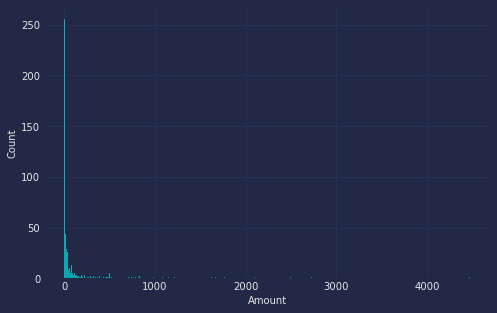

In [37]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(fraud_data.Amount, ax=ax)

In [43]:
len(fraud_data[fraud_data.Amount==0]), len(fraud_data[fraud_data.Amount==0]) / len(fraud_data) * 100

(12, 2.55863539445629)

That's a bit weird. How come 2.5% of the fraudulent transactions have a transaction amount equal to ZERO? :/

In [52]:
len(train[(train.Amount==0) & (train.Class==0)]), len(train[(train.Amount==0) & (train.Class==0)]) / len(train) * 100

(1834, 0.8369499244737119)

Hmm, but in case of non-fraudulent transactions, only 0.83% have a amount of 0. weird

# Let's train LightGBM on new feature engineered dataset

In [67]:
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,is_night
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0,0.0,1
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0,0.0,1
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0,0.0,1
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0,0.0,1
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0,0.0,1


In [68]:
test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V22,V23,V24,V25,V26,V27,V28,Amount,Hour,is_night
0,219129,120580.0,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,...,0.682524,0.037769,-0.546859,-0.123055,-0.084889,0.004720,-0.021944,29.95,9.0,0
1,219130,120580.0,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,...,1.294571,0.309541,3.703925,-0.242579,0.068708,0.002629,0.064690,163.50,9.0,0
2,219131,120580.0,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,...,0.086623,0.291375,0.739087,-0.543006,-0.297813,0.043699,-0.037855,16.00,9.0,0
3,219132,120580.0,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,...,-0.010732,-0.038550,0.656830,0.343470,-0.627529,-0.024338,-0.036143,120.98,9.0,0
4,219133,120580.0,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,...,-0.306918,0.247822,-0.391799,-0.790716,-0.025706,0.330758,0.335537,1.98,9.0,0


In [77]:
y_2 = train.Class
X_train_2 = train.drop(columns=["id", "Class"])
X_test_2 = test.drop(columns="id")

# Scaling v2

In [78]:
feats_to_scale = ["Time", "Amount"]
sc_2 = StandardScaler()
sc_2.fit(X_train_2[feats_to_scale])
X_train_2[feats_to_scale] = sc_2.transform(X_train_2[feats_to_scale])
X_test_2[feats_to_scale] = sc_2.transform(X_test_2[feats_to_scale])

# Encoding the Hour feature

In [85]:
cat_feats = ["Hour"]
loo = LeaveOneOutEncoder(sigma=0.05)
loo.fit(X_train_2[cat_feats], y_2)
X_train_2[cat_feats] = loo.transform(X_train_2[cat_feats])
X_test_2[cat_feats] = loo.transform(X_test_2[cat_feats])
X_train_2.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Hour,is_night
0,-2.434688,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,...,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,-0.426937,0.0,1
1,-2.434688,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,...,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,0.116982,0.0,1
2,-2.434688,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,...,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,-0.422228,0.0,1
3,-2.434688,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,...,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,-0.433436,0.0,1
4,-2.434688,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,...,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,-0.433436,0.0,1


In [88]:
from optuna.integration import LightGBMPruningCallback

def objective_lgbm(trial, X, y):
    param_grid = {
        "device_type": "gpu",
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000),
        "num_rounds": trial.suggest_int("num_rounds", 100, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 200),
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
        "lambda_l1": trial.suggest_loguniform('lambda_l1', 0.00001, 10),
        "lambda_l2": trial.suggest_loguniform('lambda_l2', 0.00001, 10),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 100),
        "bagging_fraction":  trial.suggest_loguniform('bagging_fraction', 0.2, 0.9),
        "feature_fraction": trial.suggest_loguniform('feature_fraction', 0.2, 0.9),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 50, 500),
        "verbose": -1,
    }

    N_FOLDS = 10
    all_scores = np.zeros(N_FOLDS)

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

            
        model = lgbm.LGBMClassifier(objective="binary", is_unbalance=True, **param_grid)
        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            verbose=-1,
        )
        y_preds = model.predict_proba(X_val)[:, 1]
        all_scores[fold_id] = roc_auc_score(y_val, y_preds)
    
    auc = np.mean(all_scores)
    print(f"AVG CV AUC: \t {auc}")
    return auc

In [ ]:
study_lgbm = optuna.create_study(direction="maximize", study_name="LGBM Tuning")
func = lambda trial: objective_lgbm(trial, X_train_2, y_2)
study_lgbm.optimize(func, n_trials=100, show_progress_bar=True)